In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import random
import gym
import pdb

from src.utils.OUNoise import OUNoise 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define Networks

In [4]:
class Actor(nn.Module):
    def __init__(self, state_space, action_space):
        super(Actor, self).__init__()
        
        self.noise = OUNoise(action_space)
        
        self.head = nn.Sequential(
            nn.Linear(state_space, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, action_space),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.head(x)
    
    def act(self, state, add_noise=True):
        
        state = torch.from_numpy(state).float()
        
        action = self.forward(state).cpu().data.numpy()
        if add_noise:
            action += self.noise.noise()

        return np.clip(action, -1, 1)


In [5]:
# class Critic(nn.Module):
#     def __init__(self, state_space, action_space):
#         super(Critic, self).__init__()
        
#         self.head = nn.Sequential(
#             nn.Linear(state_space, 1024),
#             nn.ReLU(),
#         )
        
#         self.body = nn.Sequential(
#             nn.Linear(1024 + action_space, 512),
#             nn.ReLU(),
#             nn.Linear(512, 300),
#             nn.ReLU(),
#             nn.Linear(300, 1),
#         )
        
#         self.single = nn.Sequential(
#             nn.Linear(state_space + action_space, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 1),
#         )
    
#     def forward(self, x, actions):
#         actions = torch.tensor(actions).float()
#         x = torch.tensor(x).float()
        
#         x = self.head(x)
#         x = self.body(torch.cat((x, actions), dim=1))
        
# #         x = self.single(torch.cat((x, actions), dim=1))
#         return x

In [6]:
class Critic(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 1024)
        self.linear2 = nn.Linear(1024 + self.action_dim, 512)
        self.linear3 = nn.Linear(512, 300)
        self.linear4 = nn.Linear(300, 1)

    def forward(self, x, a):
        x = F.relu(self.linear1(x))
        xa_cat = torch.cat([x,a], 1)
        xa = F.relu(self.linear2(xa_cat))
        xa = F.relu(self.linear3(xa))
        qval = self.linear4(xa)

        return qval

## Create environment with Agents

https://github.com/openai/gym/wiki/Pendulum-v0

In [7]:
import gym

# env = gym.make("MountainCarContinuous-v0")
env = gym.make("Pendulum-v0")

state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

print("State space: {}".format(state_space))
print("Action space: {}".format(action_space))

State space: 3
Action space: 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
actor = Actor(state_space, action_space).to(device)
critic = Critic(state_space, action_space).to(device)

actor_target = Actor(state_space, action_space).to(device)
critic_target = Critic(state_space, action_space).to(device)

### Replay Buffer

In [10]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=int(buffer_size))
        self.Experience = namedtuple("experience", ["state", "action", "reward", "next_state", "done"])
    
    def push(self, state, action, reward, next_state, done):
        e = self.Experience(state, action, np.array([reward]), next_state ,done)
        self.buffer.append(e)
    
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        
        states = [ exp.state for exp in samples]
        actions = [ exp.action for exp in samples]
        rewards = [ exp.reward for exp in samples]
        next_states = [ exp.next_state for exp in samples]
        dones = [ exp.done for exp in samples]
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.buffer)

## Computing loss and updating Networks

In [11]:
actor_optimiser = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimiser = optim.Adam(critic.parameters(), lr=1e-3)

In [12]:
def learn():

    state_batch, action_batch, reward_batch, next_state_batch, masks = mem.sample(batch_size)
    
    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.FloatTensor(action_batch)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    masks = torch.FloatTensor(masks)


    update_critic(
        states=state_batch,
        next_states=next_state_batch,
        actions=action_batch,
        rewards=reward_batch,
        dones=masks
    )
    update_actor(states=state_batch)
    update_target_networks()


### Actor Update

<img src="./img/ddpg/actor_update.png" alt="Drawing" style="height: 50px;"/>

In [13]:
def update_actor(states):
    actions_pred = actor(states)  
    loss = -critic(states, actions_pred).mean()
    
    actor_optimiser.zero_grad()
    loss.backward()
    actor_optimiser.step()

### Critic Update

Critic Loss:
<img src="./img/ddpg/critic_loss.png" alt="Drawing" style="height: 30px;"/>

Critic $y_i$:
<img src="./img/ddpg/critic_yi.png" alt="Drawing" style="height: 35px;"/>

In [14]:
def update_critic(states, next_states, actions, rewards, dones):
    next_actions = actor_target.forward(next_states)
    
    y_i =  rewards + ( gamma * critic_target(next_states, next_actions) * (1-dones ))
    expected_Q = critic(states, actions)

    loss = F.mse_loss(y_i, expected_Q)
    
    critic_optimiser.zero_grad()
    loss.backward()
    critic_optimiser.step()

### Copy Weights Over

In [15]:
def update_target_networks():
    for target, local in zip(actor_target.parameters(), actor.parameters()):
        target.data.copy_(tau*local.data + (1.0-tau)*target.data)
        
    for target, local in zip(critic_target.parameters(), critic.parameters()):
        target.data.copy_(tau*local.data + (1.0-tau)*target.data)

## Runner

In [20]:
max_e = 300
max_t = 500
buffer_size = 100000
batch_size = 32
learn_every = 1

gamma = 0.99
tau = 1e-2

In [17]:
mem = ReplayBuffer(buffer_size)

score_log = []
score_window = deque(maxlen=100)

In [21]:
for episode in range(max_e):
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        mem.push(state, action, reward, next_state, done)
        score += reward


        
        if len(mem) > batch_size and t % learn_every == 0:
            learn()

        if done:
            break;
        
        state = next_state
    
    score_log.append(score)
    score_window.append(score)
    
#     print("\rEpsiode: {:.1f}\tWindow Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score), end="")    
#     if (episode % 100 == 0):
#         print("\rEpsiode: {:.1f}\tWindow Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score))
    print("\rEpsiode: {:.1f}\tMean Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score))




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


Epsiode: 0.0	Mean Score: -723.9885	Score: -128.5097
Epsiode: 1.0	Mean Score: -705.3404	Score: -127.2470
Epsiode: 2.0	Mean Score: -698.6947	Score: -486.0341
Epsiode: 3.0	Mean Score: -681.8138	Score: -124.7451
Epsiode: 4.0	Mean Score: -669.4169	Score: -247.9212
Epsiode: 5.0	Mean Score: -657.8248	Score: -252.1006
Epsiode: 6.0	Mean Score: -643.4520	Score: -126.0304
Epsiode: 7.0	Mean Score: -640.1857	Score: -519.3338
Epsiode: 8.0	Mean Score: -623.8489	Score: -3.0514
Epsiode: 9.0	Mean Score: -611.4766	Score: -128.9550
Epsiode: 10.0	Mean Score: -599.5574	Score: -122.7909
Epsiode: 11.0	Mean Score: -588.2952	Score: -126.5428
Epsiode: 12.0	Mean Score: -583.0838	Score: -364.2055
Epsiode: 13.0	Mean Score: -569.9233	Score: -4.0247
Epsiode: 14.0	Mean Score: -562.5000	Score: -235.8721
Epsiode: 15.0	Mean Score: -553.0546	Score: -128.0142
Epsiode: 16.0	Mean Score: -549.1617	Score: -370.0856
Epsiode: 17.0	Mean Score: -545.4121	Score: -369.1816
Epsiode: 18.0	Mean Score: -539.1262	Score: -237.4022
Epsiode

Epsiode: 155.0	Mean Score: -238.4791	Score: -0.4490
Epsiode: 156.0	Mean Score: -238.3586	Score: -495.2005
Epsiode: 157.0	Mean Score: -238.3552	Score: -126.8823
Epsiode: 158.0	Mean Score: -237.4138	Score: -505.5656
Epsiode: 159.0	Mean Score: -238.6164	Score: -125.7797
Epsiode: 160.0	Mean Score: -239.7440	Score: -241.1408
Epsiode: 161.0	Mean Score: -236.9993	Score: -359.5291
Epsiode: 162.0	Mean Score: -235.7898	Score: -125.1525
Epsiode: 163.0	Mean Score: -236.9548	Score: -242.2741
Epsiode: 164.0	Mean Score: -238.1571	Score: -125.5764
Epsiode: 165.0	Mean Score: -235.5113	Score: -239.9002
Epsiode: 166.0	Mean Score: -236.5448	Score: -467.5660
Epsiode: 167.0	Mean Score: -236.4854	Score: -121.8779
Epsiode: 168.0	Mean Score: -236.4390	Score: -125.0571
Epsiode: 169.0	Mean Score: -235.2332	Score: -121.9280
Epsiode: 170.0	Mean Score: -234.0618	Score: -124.9833
Epsiode: 171.0	Mean Score: -232.7083	Score: -120.9890
Epsiode: 172.0	Mean Score: -233.7395	Score: -232.5367
Epsiode: 173.0	Mean Score: -23

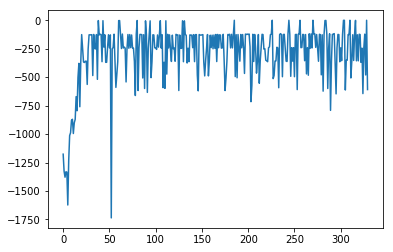

In [22]:
plt.plot(score_log)

## Watch

In [27]:
for episode in range(3):
    state = env.reset()
    score = 0
    input()

    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        env.render()
        
        score += reward
        
        if done:
            print(score)
            break;

env.close()


-1522.3271243317822

-1186.9506447086071

-1173.126308050237
